# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)


## 1.1. Подготовка данных (0.5 балла)


In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from skimage.transform import resize
from torch.autograd import Variable
from torchvision import datasets, transforms as tfs
from torchsummary import summary

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [3]:
from tqdm.notebook import tqdm, trange
from IPython.display import clear_output
import warnings
import copy

plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (7, 4)
%config InlineBackend.figure_format = "retina"
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
# first, fix all random seed for this notebook
SEED = 2147483647

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
def fetch_dataset(attrs_name="lfw_attributes.txt",
                  images_name="lfw-deepfunneled",
                  dx=80,
                  dy=80,
                  dimx=64,
                  dimy=64):

    # download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system(
            "wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz"
        )
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system(
            "wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"
            % attrs_name)
        print("done")

    # read attrs
    df_attrs = pd.read_csv(
        "lfw_attributes.txt",
        sep='\t',
        skiprows=1,
    )
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values,
                            columns=df_attrs.columns[1:])

    # read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({
                    'person': person_id,
                    'imagenum': photo_number,
                    'photo_path': fpath
                })

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    # mass-merge
    # (photos now have same order as attributes)
    df = pd.merge(df_attrs, photo_ids, on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    # print(df.shape)
    # image preprocessing
    all_photos = df['photo_path'].apply(skimage.io.imread)\
        .apply(lambda img: img[dy:-dy, dx:-dx])\
        .apply(lambda img: resize(img, [dimx, dimy]))

    all_photos = np.stack(all_photos.values)  # .astype('uint8')
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [6]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()

Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:


In [7]:
n = len(data)

ids = np.random.choice(n, n, replace=False)
train_part = int(n * 0.9)
ids_tr, ids_val = np.split(ids, [train_part])

data_train, data_valid = data[ids_tr], data[ids_val]
attrs_train, attrs_valid = attrs.iloc[ids_tr], attrs.iloc[ids_val]

data_train = torch.tensor(np.moveaxis(data_train, 3, 1), dtype=torch.float32)
data_valid = torch.tensor(np.moveaxis(data_valid, 3, 1), dtype=torch.float32)

print("Train shape: ", data_train.shape)
print("Valid shape: ", data_valid.shape)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=32)
valid_loader = torch.utils.data.DataLoader(data_valid, batch_size=32)

Train shape:  torch.Size([8120, 3, 64, 64])
Valid shape:  torch.Size([903, 3, 64, 64])


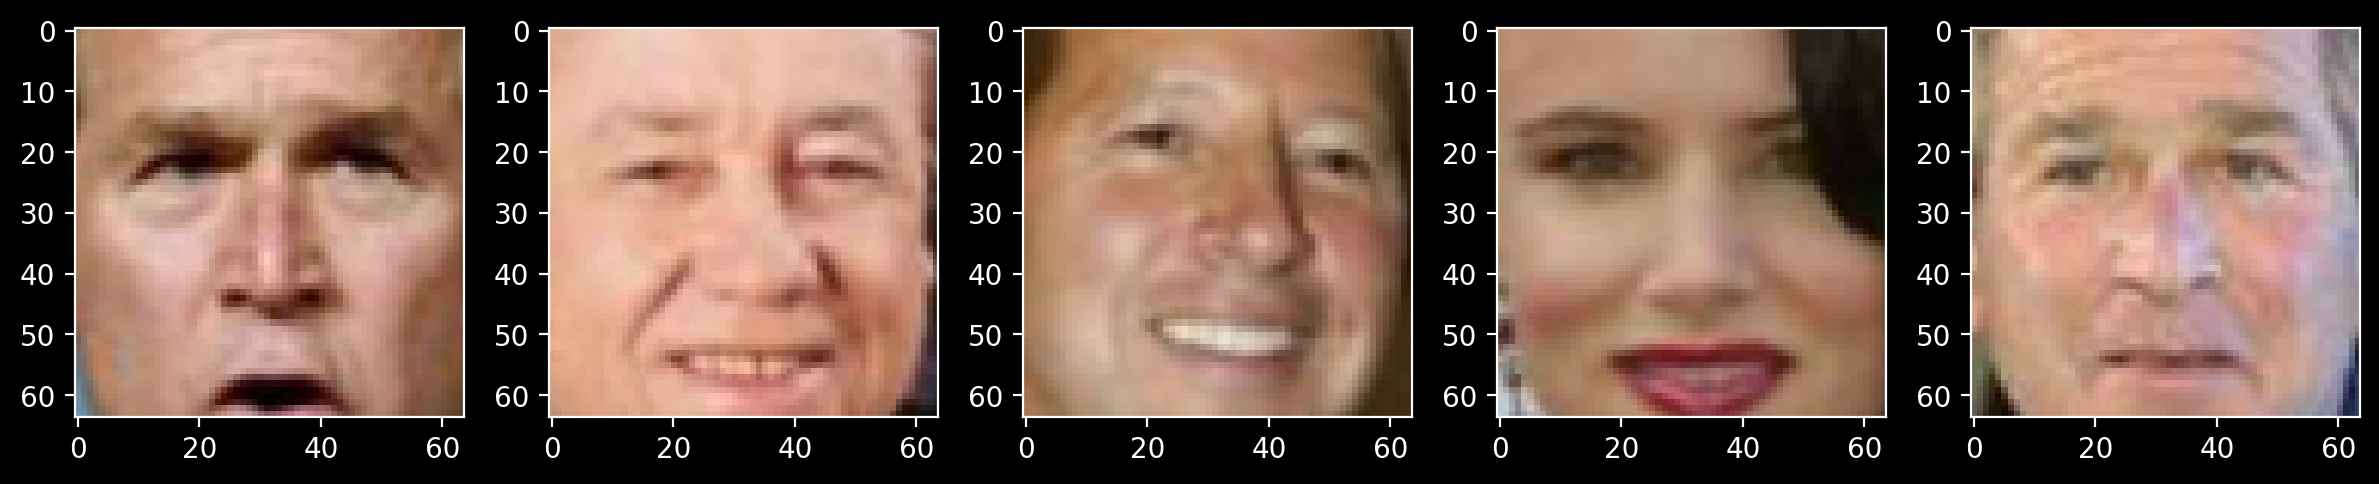

In [8]:
# выводим несколько картинок из тренировочной выборки
ids = np.random.choice(len(data_train), 5)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(ids):
    plt.subplot(1, 5, i + 1)
    img = torch.moveaxis(data_train[idx], 0, 2)
    plt.imshow(img)
plt.tight_layout()

## 1.2. Архитектура модели (1.5 балла)

В этом разделе мы напишем и обучем обычный автоэнкодер.

<!-- <img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder" height="400px"> -->

^ напомню, что автоэнкодер выглядит вот так


Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!


```Python
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder>

    def forward(self, x):

        <реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code)
        и полученная реконструкция изображения (reconstruction)>

        return reconstruction, latent_code
```


In [9]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels: int, hidden: int, latent_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden, 3, stride=2,
                      padding=1),  # 64x64 => 32x32
            nn.ReLU(),
            nn.Conv2d(hidden, 2 * hidden, kernel_size=3,
                      padding=1, stride=2),  # 32x32 => 16x16
            nn.ReLU(),
            nn.Conv2d(2 * hidden, 2 * hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2 * hidden, 3 * hidden, kernel_size=3,
                      padding=1, stride=2),  # 16x16 => 8x8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * hidden * 8 * 8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                3 * hidden, 2 * hidden, kernel_size=3, output_padding=1, padding=1, stride=2  # 8x8 => 16x16
            ),
            nn.ReLU(),
            nn.Conv2d(2 * hidden, 2 * hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2 * hidden, hidden, kernel_size=3,  # 16x16 => 32x32
                               output_padding=1, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(
                hidden, in_channels, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 32x32 => 64x64
            nn.Sigmoid()
        )
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 3 * hidden * 8 * 8),
            nn.ReLU()
        )

    def forward(self, x):
        latent = self.encoder(x)
        x = self.linear(latent)
        x = x.reshape(x.shape[0], -1, 8, 8)
        recon = self.decoder(x)
        return recon, latent

    def sample(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 8, 8)
        return self.decoder(x)

    def get_latent_vector(self, x):
        return self.encoder(x)

## 1.3 Обучение (2 балла)


Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)


In [10]:
def plot_results(history: dict, epoch: int, n_epochs: int, img_orig, img_recon):

    clear_output()
    train_loss = history["train_loss"][-1]
    valid_loss = history["valid_loss"][-1]

    img_orig = torch.moveaxis(img_orig.detach().cpu(), 0, 2)
    img_recon = torch.moveaxis(img_recon.detach().cpu(), 0, 2)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={
                            "width_ratios": [2, 1, 1]})

    ax = axs[0]
    for key in history.keys():
        ax.plot(history[key], label=f"{key}")
        ax.set(title=f"*Epoch {epoch+1} of {n_epochs} | train_loss: {train_loss:.5f}, valid_loss {valid_loss:.5f}",
               xlabel="epochs", ylabel="loss")
        ax.legend(loc="upper right")

    ax = axs[1]
    ax.imshow(img_orig)
    ax.set(title="Original")

    ax = axs[2]
    ax.imshow(img_recon)
    ax.set(title="Reconstructed")

    plt.show()

In [11]:
latent_dim = 512
criterion = F.mse_loss
model = Autoencoder(in_channels=3, latent_dim=latent_dim, hidden=64)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=12288, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(192, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(6

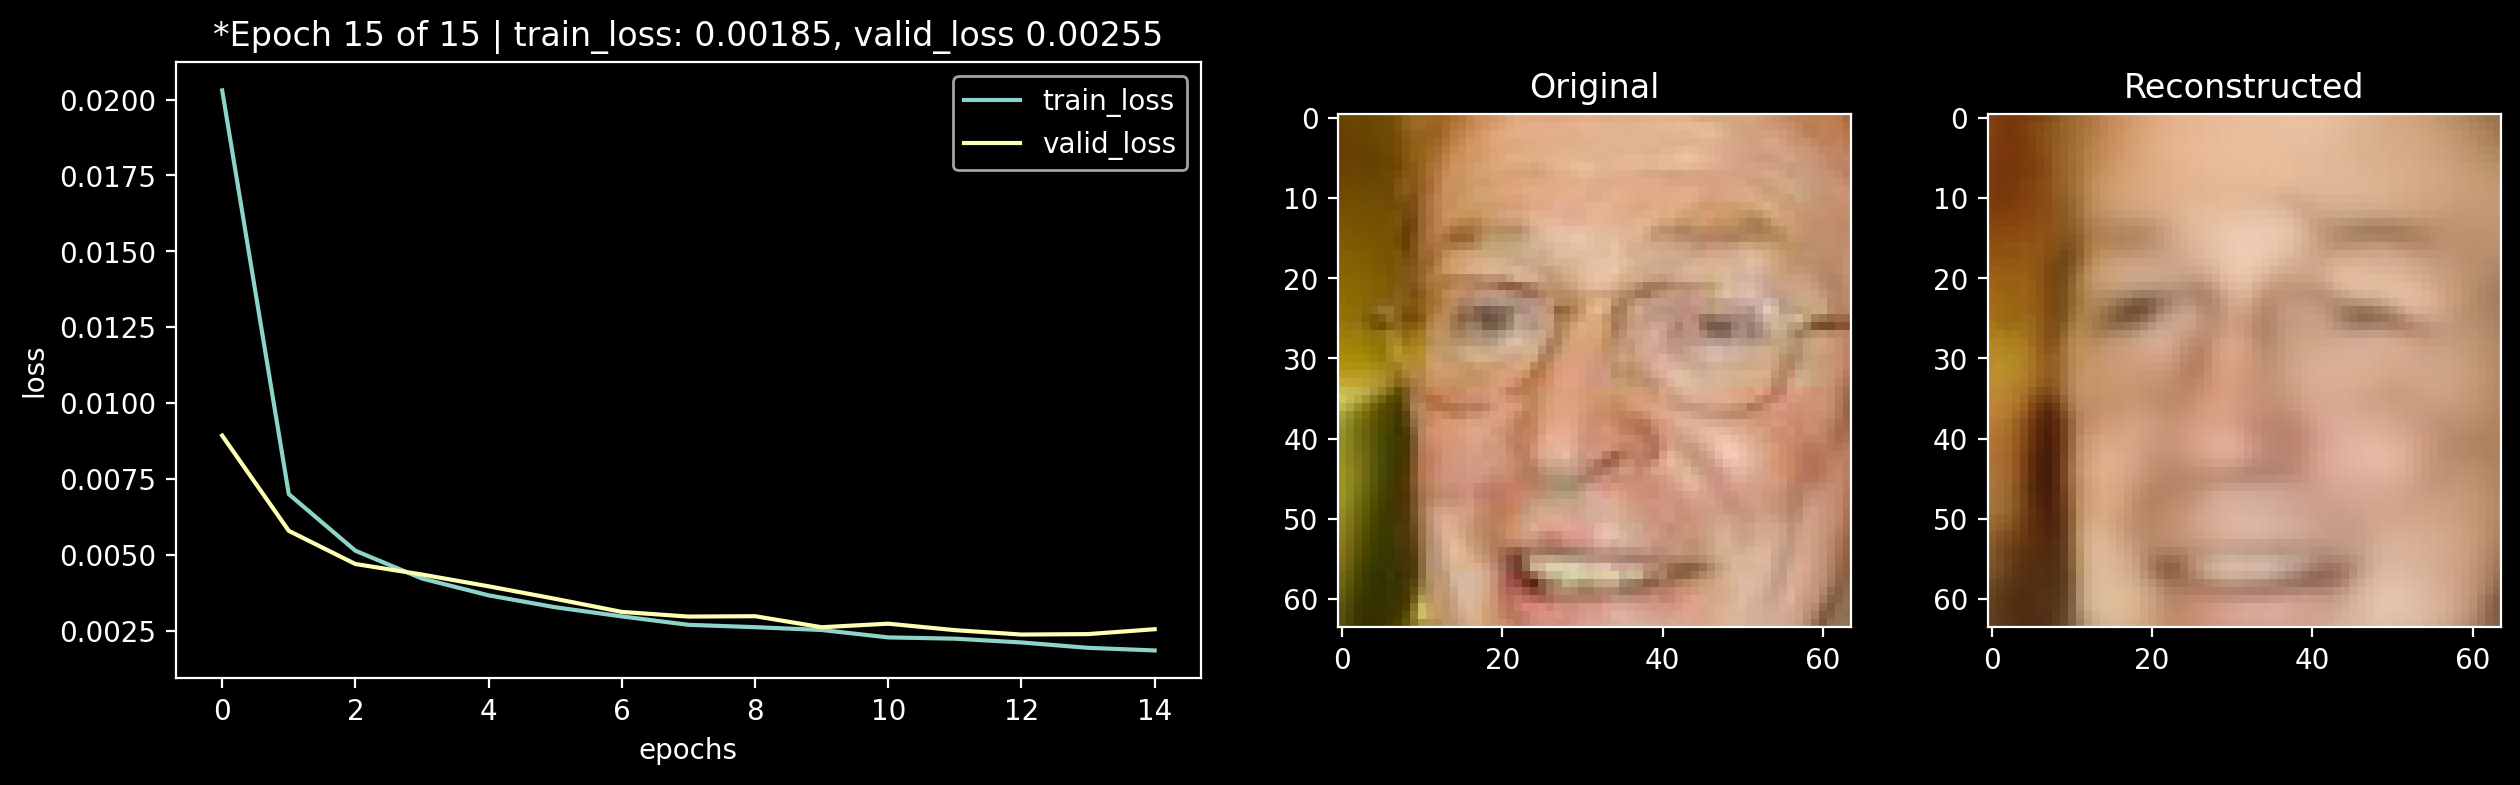

<All keys matched successfully>

In [12]:
n_epochs = 15
history = {"train_loss": [], "valid_loss": []}
best_loss_valid = 1e3

for epoch in range(n_epochs):

    avg_loss_train = 0
    model.train()

    for batch in train_loader:
        batch = batch.to(device)  # data to device
        optimizer.zero_grad()  # reset gradients

        recon, latent = model(batch)
        loss = criterion(recon, batch)

        loss.backward()
        optimizer.step()

        avg_loss_train += loss.item() / len(train_loader)

    history["train_loss"].append(avg_loss_train)

    avg_loss_valid = 0
    model.eval()

    with torch.no_grad():
        for val_batch in valid_loader:
            val_batch = val_batch.to(device)
            recon, latent = model(val_batch)
            loss = criterion(recon, val_batch)

            avg_loss_valid += loss.item() / len(valid_loader)

    if avg_loss_valid < best_loss_valid:
        best_loss_valid = avg_loss_valid
        best_model_wts = copy.deepcopy(model.state_dict())

    history["valid_loss"].append(avg_loss_valid)
    plot_results(history, epoch, n_epochs, val_batch[0], recon[0])

model.load_state_dict(best_model_wts)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:


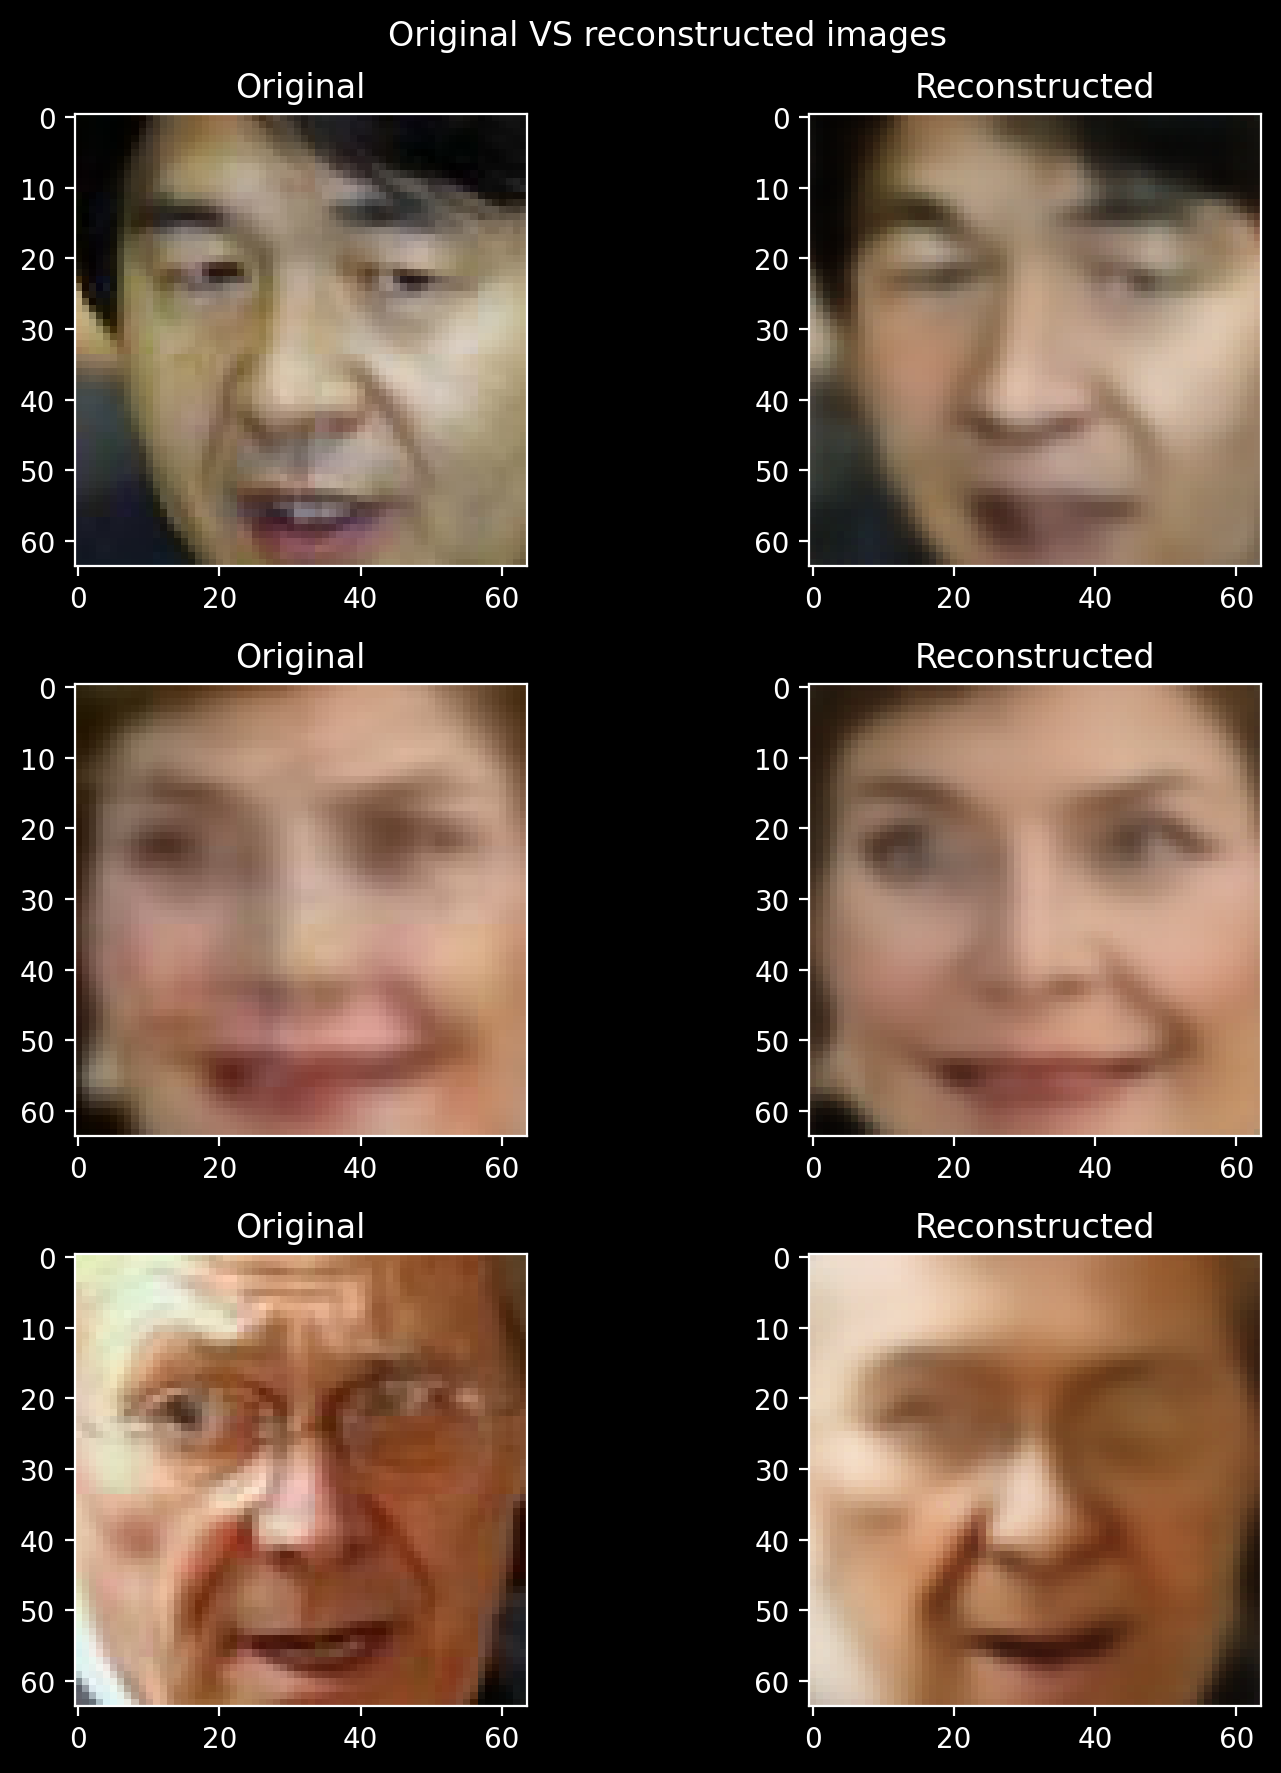

In [13]:
n2plot = 3
val_batch = next(iter(valid_loader))

fig, axs = plt.subplots(n2plot, 2, figsize=(8, 3*n2plot))
fig.suptitle("Original VS reconstructed images")

for i in range(n2plot):
    with torch.no_grad():
        recon, latent = model(val_batch.to(device))

    img_orig = torch.moveaxis(val_batch[i].detach().cpu(), 0, 2)
    img_recon = torch.moveaxis(recon[i].detach().cpu(), 0, 2)

    ax = axs[i][0]
    ax.imshow(img_orig.numpy())
    ax.set(title="Original")

    ax = axs[i][1]
    ax.imshow(img_recon.numpy())
    ax.set(title="Reconstructed")

fig.tight_layout()

Not bad, right?


## 1.4. Sampling (2 балла)


Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

**Подсказка:**Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.


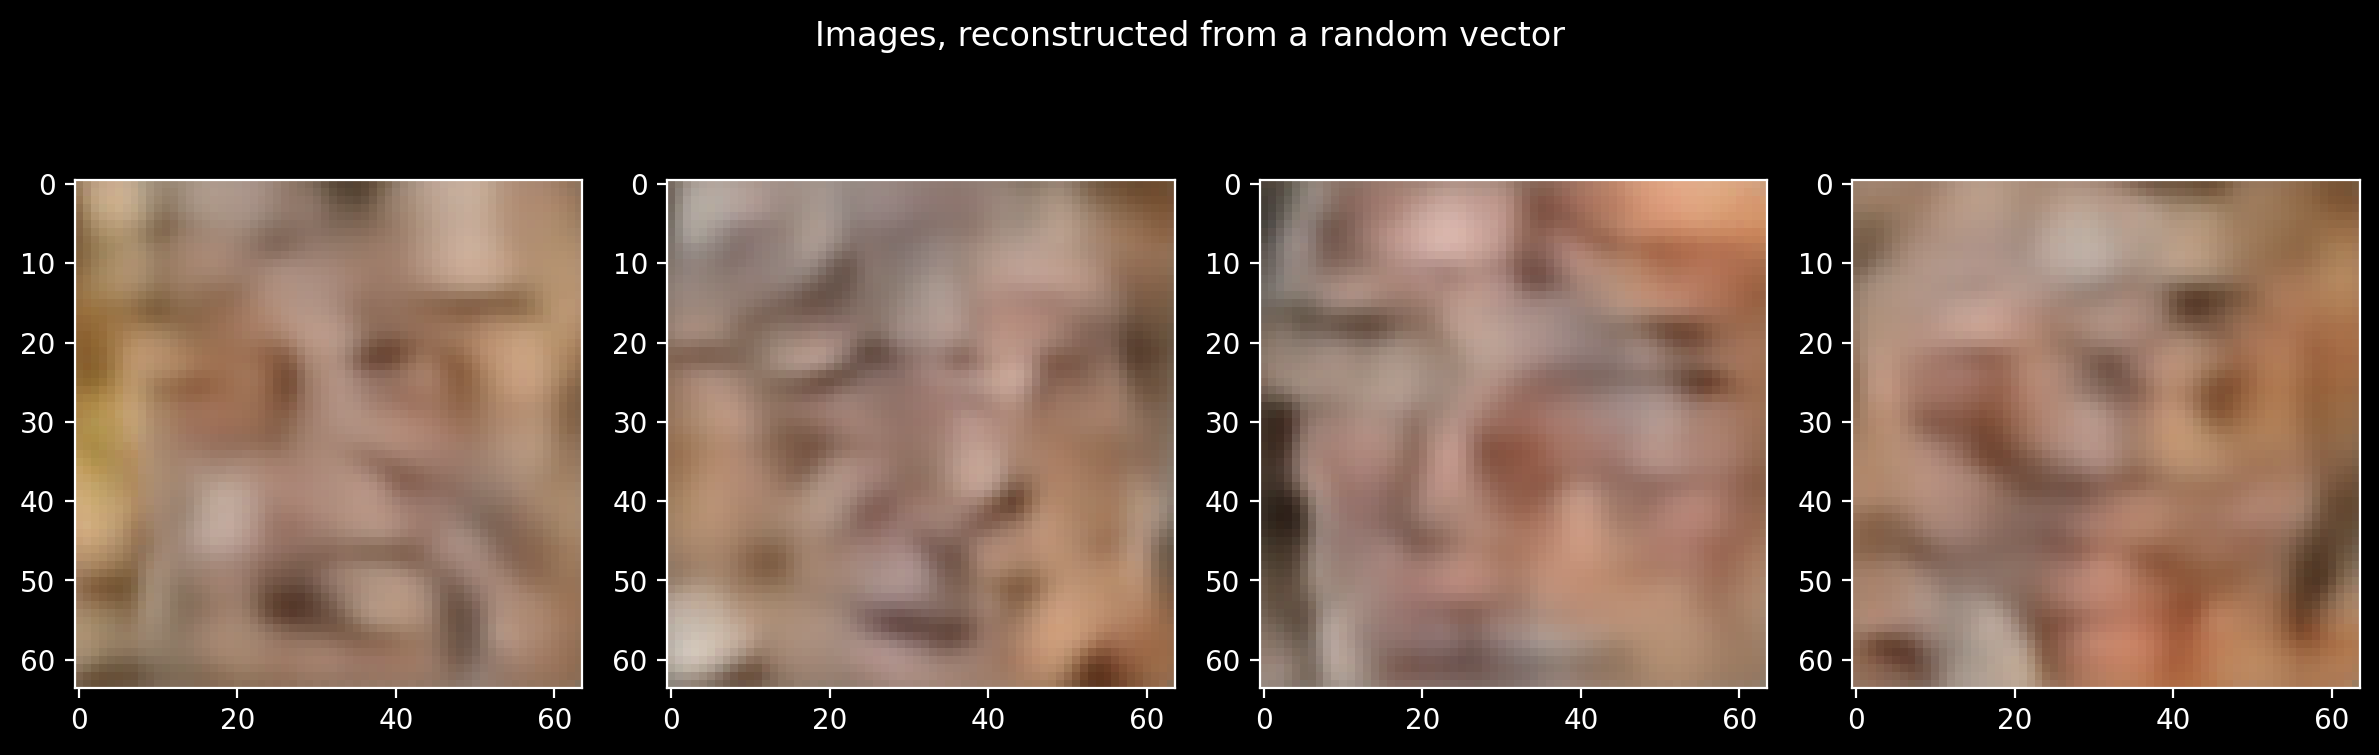

In [14]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.randn(25, latent_dim)
output = model.sample(z.to(device))

n2plot = 4
fig, axs = plt.subplots(1, n2plot, figsize=(3*n2plot, 4))
fig.suptitle("Images, reconstructed from a random vector")

for i in range(n2plot):

    img = torch.moveaxis(output[i].detach().cpu(), 0, 2)

    ax = axs[i]
    ax.imshow(img)

fig.tight_layout()

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)


<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">


План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!


Для начала, посмотрим на улыбающихся (и не очень) людей.


In [15]:
idx = attrs.query("Smiling > .99").index
idx = np.random.choice(idx, 32, False)
data_smiling = data[idx]

idx = attrs.query("Smiling < -.99").index
idx = np.random.choice(idx, 32, False)
data_grumpy = data[idx]

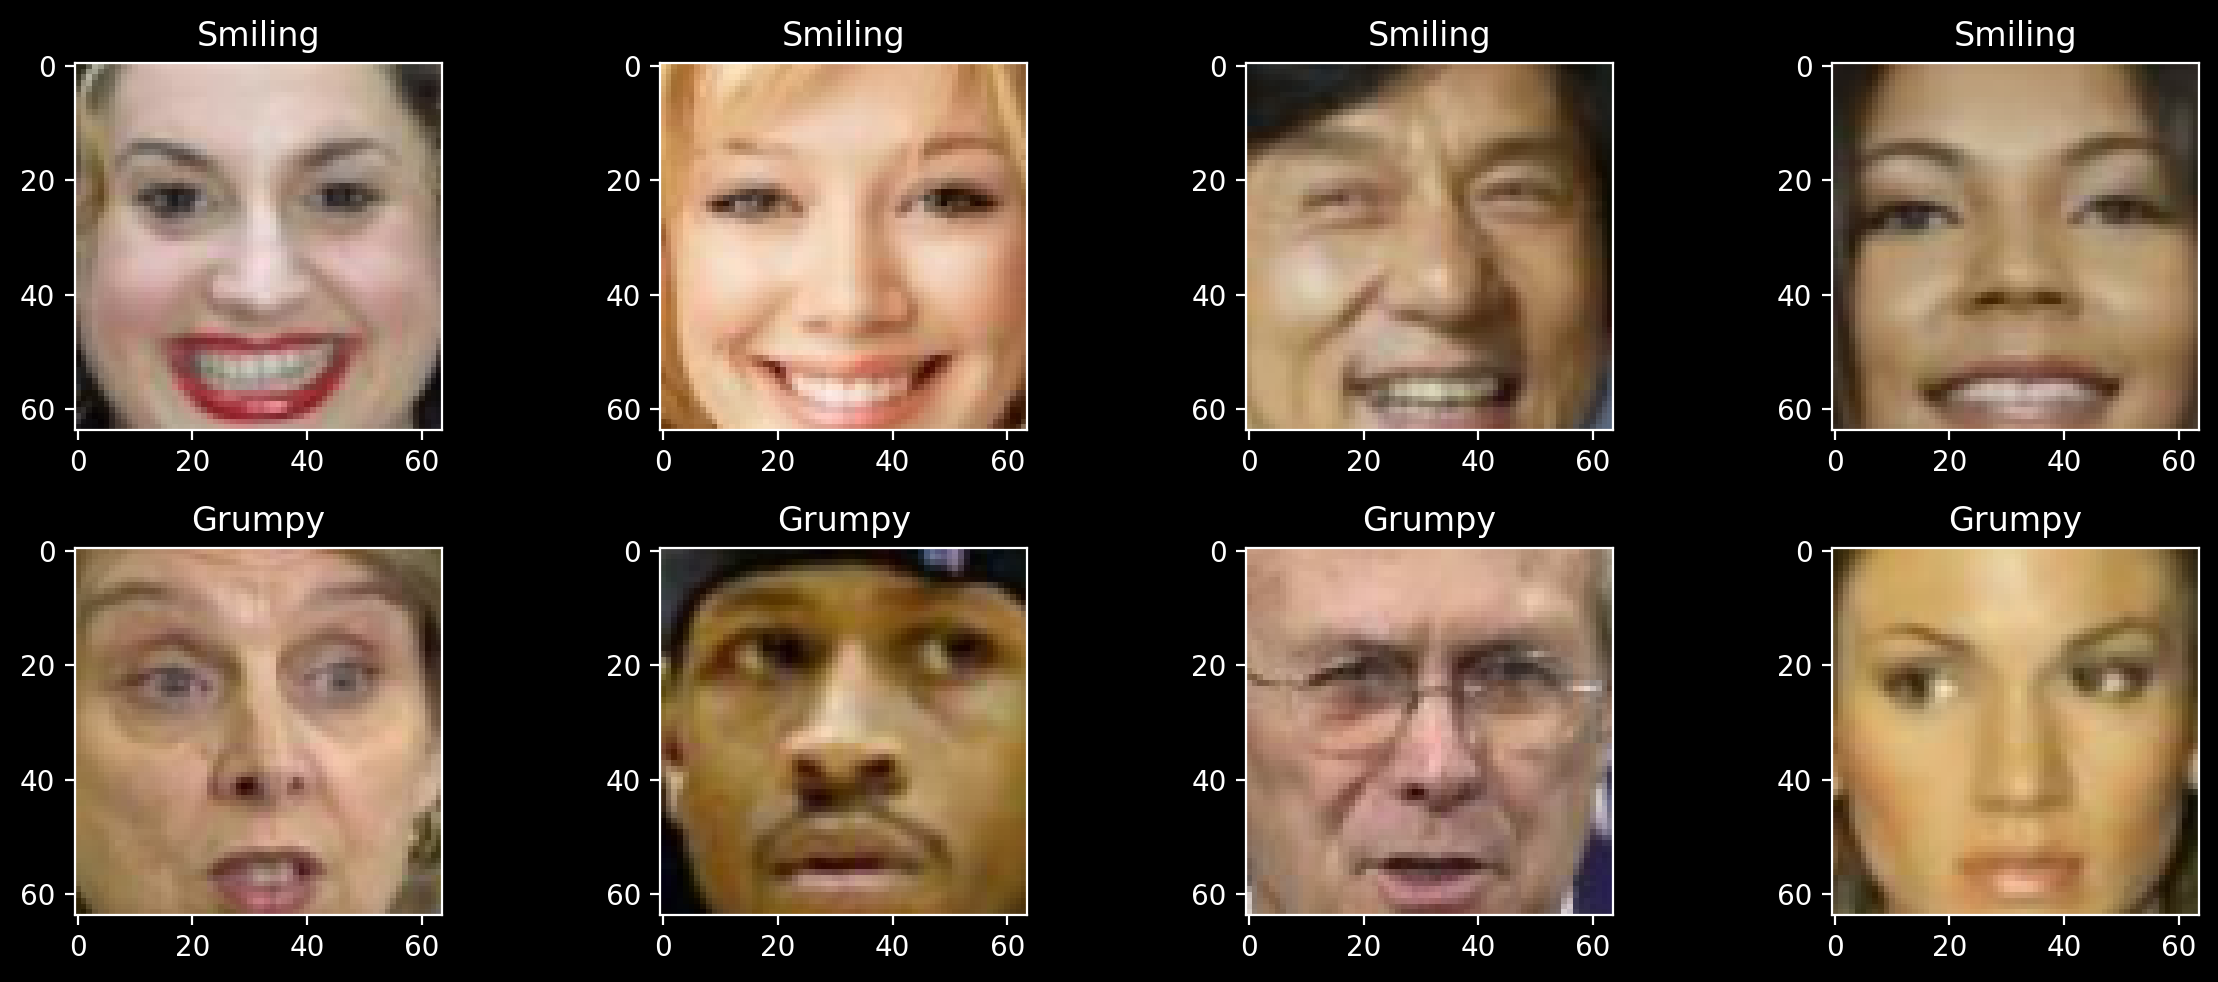

In [16]:
n2plot = 4
fig, axs = plt.subplots(2, n2plot, figsize=(3*n2plot, 5))

for i in range(n2plot):
    ax = axs[0][i]
    ax.imshow(data_smiling[i])
    ax.set(title="Smiling")

for i in range(n2plot):
    ax = axs[1][i]
    ax.imshow(data_grumpy[i])
    ax.set(title="Grumpy")

fig.tight_layout()

Вычислим латентный вектор улыбающихся людей.


In [17]:
batch = torch.tensor(np.moveaxis(data_smiling, 3, 1), dtype=torch.float32)
latent = model.get_latent_vector(batch.to(device))
latent_smiling = latent.mean(axis=0)
latent_smiling.shape

torch.Size([512])

A теперь то же самое, но для грустных.


In [18]:
batch = torch.tensor(np.moveaxis(data_grumpy, 3, 1), dtype=torch.float32)
latent = model.get_latent_vector(batch.to(device))
latent_grumpy = latent.mean(axis=0)
latent_grumpy.shape

torch.Size([512])

Посчитаем разницу


In [19]:
smile = latent_smiling - latent_grumpy

Посмотрим что вышло.


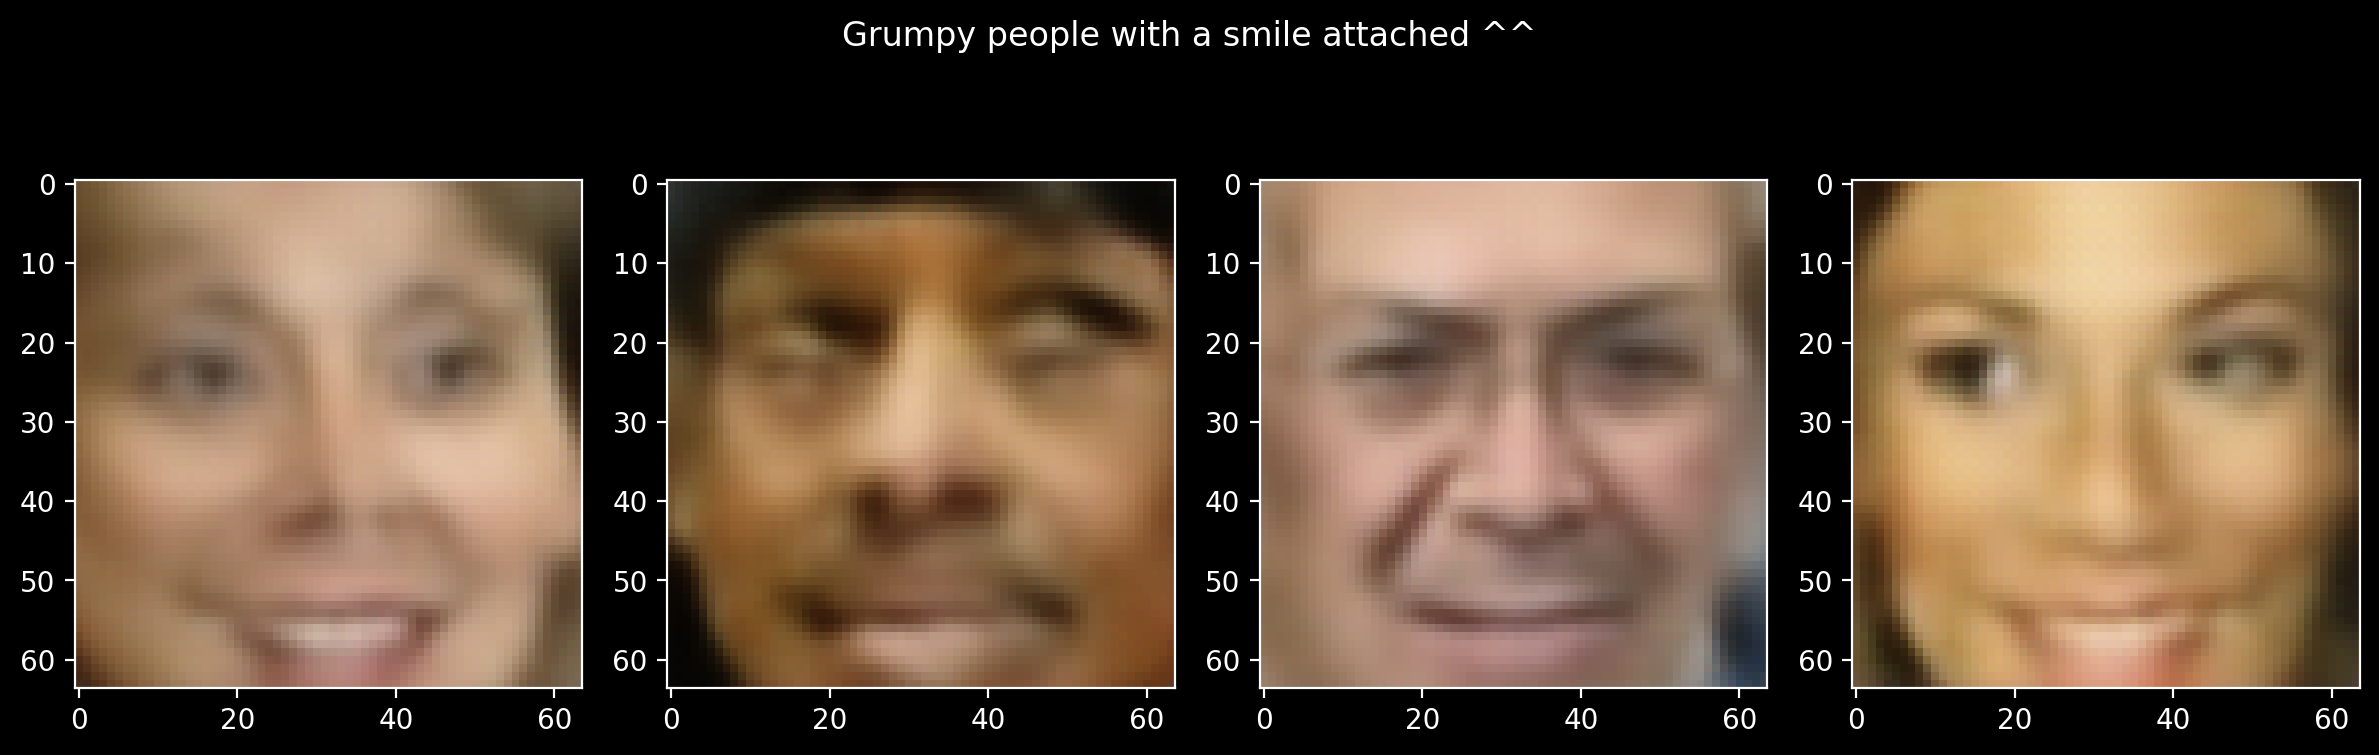

In [20]:
tmp = latent + smile
data_added_smile = model.sample(tmp.to(device))

n2plot = 4
fig, axs = plt.subplots(1, n2plot, figsize=(3*n2plot, 4))
fig.suptitle("Grumpy people with a smile attached ^^")

for i in range(n2plot):

    img = torch.moveaxis(data_added_smile[i].detach().cpu(), 0, 2)

    ax = axs[i]
    ax.imshow(img)

fig.tight_layout()

Вуаля! Вы восхитительны!


Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)


# Часть 2: Variational Autoencoder (10 баллов)


Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9


In [21]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(
    root='./mnist_data/', train=True, transform=tfs.ToTensor(), download=True)
test_dataset = datasets.MNIST(
    root='./mnist_data/', train=False, transform=tfs.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)
clear_output()

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!


### Seminar notebook materials


In [22]:
class VAE(nn.Module):
    def __init__(self, n_features: int, hidden: int, latent_dim: int):
        super(VAE, self).__init__()

        self.n_features = n_features

        # encoder
        self.e1 = nn.Linear(n_features, hidden)
        self.e2a = nn.Linear(hidden, latent_dim)
        self.e2b = nn.Linear(hidden, latent_dim)

        self.d1 = nn.Linear(latent_dim, hidden)
        self.d2 = nn.Linear(hidden, n_features)

    def encode(self, x):
        h1 = F.relu(self.e1(x))
        mu = self.e2a(h1)
        log_var = self.e2b(h1)
        return mu, log_var

    def gaussian_sampler(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h3 = F.relu(self.d1(z))
        recon = F.sigmoid(self.d2(h3)).view(-1, 1, 28, 28)
        return recon

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, self.n_features))
        z = self.gaussian_sampler(mu, log_var)
        recon = self.decode(z)
        return mu, log_var, recon

Определим лосс и его компоненты для VAE:


Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.


In [23]:
def loss_vae(x, mu, log_var, recon):
    BCE = F.binary_cross_entropy(recon, x, reduction="sum")
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [24]:
latent_dim = 16
criterion = loss_vae
vae = VAE(n_features=28*28, hidden=256, latent_dim=latent_dim)
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3)
vae.to(device)

VAE(
  (e1): Linear(in_features=784, out_features=256, bias=True)
  (e2a): Linear(in_features=256, out_features=16, bias=True)
  (e2b): Linear(in_features=256, out_features=16, bias=True)
  (d1): Linear(in_features=16, out_features=256, bias=True)
  (d2): Linear(in_features=256, out_features=784, bias=True)
)

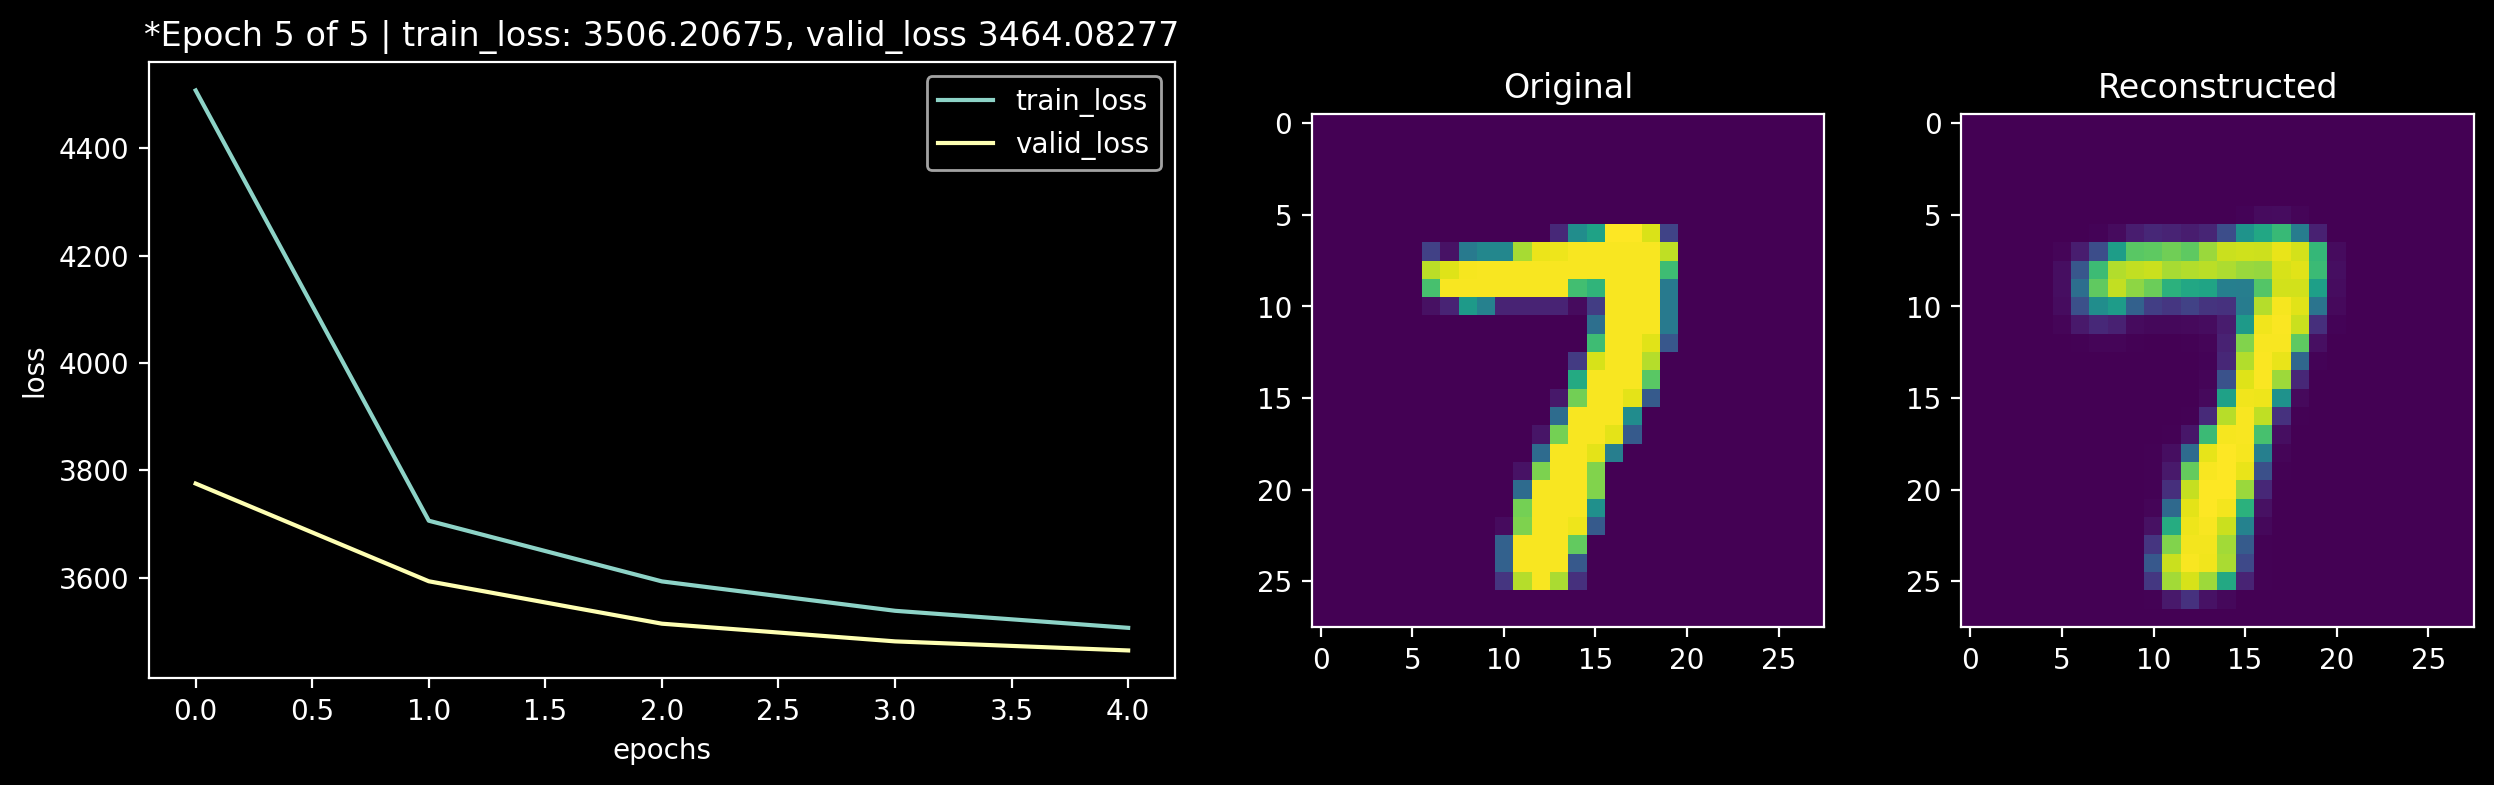

In [25]:
# <обучите модель на датасете MNIST >
n_epochs = 5
history = {"train_loss": [], "valid_loss": []}

for epoch in range(n_epochs):

    avg_loss_train = 0
    vae.train()

    for batch, _ in train_loader:
        batch = batch.to(device)  # data to device
        optimizer.zero_grad()  # reset gradients

        mu, log_var, recon = vae(batch)
        loss = criterion(batch.float(), mu, log_var, recon)

        loss.backward()
        optimizer.step()

        avg_loss_train += loss.item() / len(train_loader)

    history["train_loss"].append(avg_loss_train)

    avg_loss_valid = 0
    vae.eval()

    with torch.no_grad():
        for test_batch, _ in test_loader:
            test_batch = test_batch.to(device)

            mu, log_var, recon = vae(test_batch)
            loss = criterion(test_batch.float(), mu, log_var, recon)

            avg_loss_valid += loss.item() / len(test_loader)

    history["valid_loss"].append(avg_loss_valid)
    plot_results(history, epoch, n_epochs, test_batch[6], recon[6])

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:


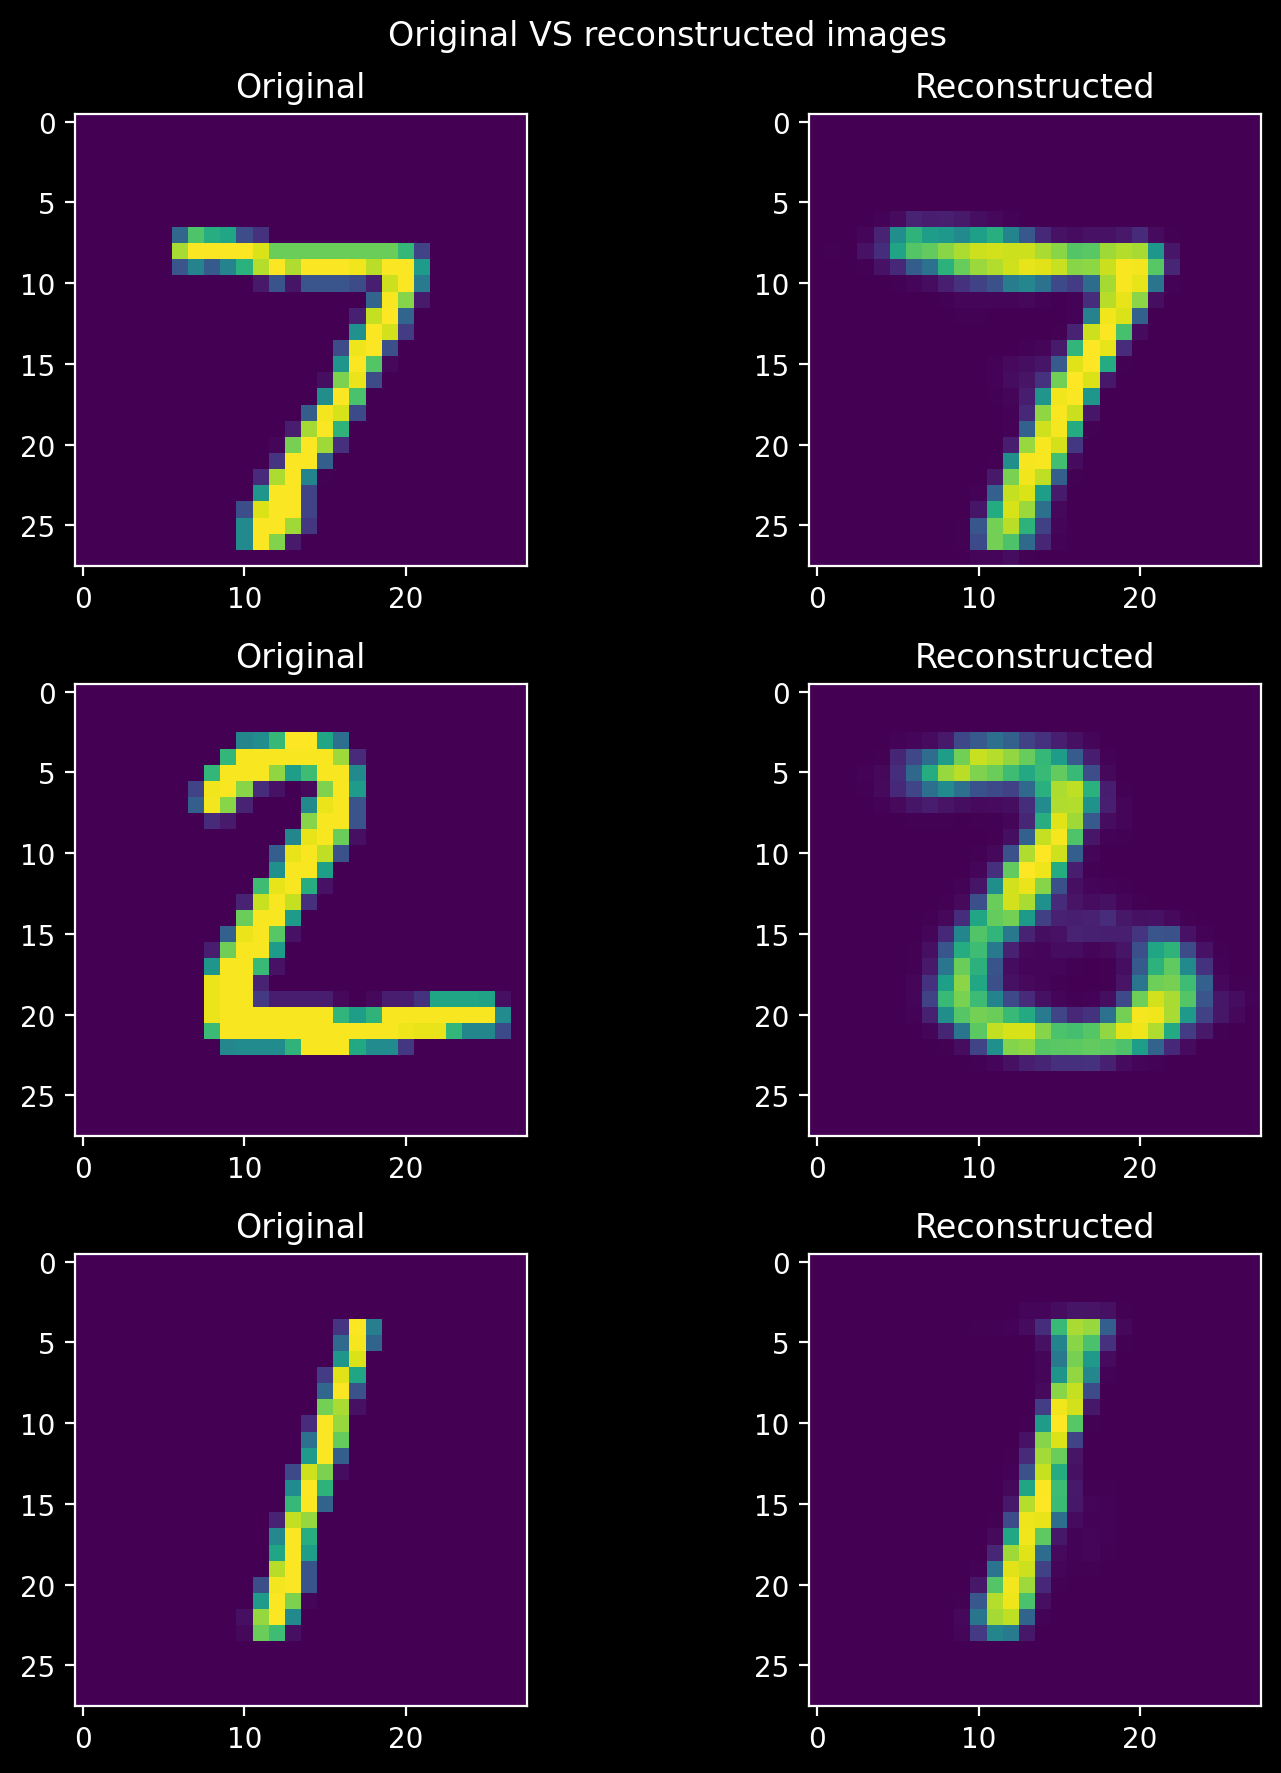

In [26]:
n2plot = 3
test_batch, digits = next(iter(test_loader))

fig, axs = plt.subplots(n2plot, 2, figsize=(8, 3*n2plot))
fig.suptitle("Original VS reconstructed images")

for i in range(n2plot):
    with torch.no_grad():
        mu, sigma, recon = vae(test_batch.to(device))

    img_orig = torch.moveaxis(test_batch[i].detach().cpu(), 0, 2)
    img_recon = torch.moveaxis(recon[i].detach().cpu(), 0, 2)

    ax = axs[i][0]
    ax.imshow(img_orig)
    ax.set(title="Original")

    ax = axs[i][1]
    ax.imshow(img_recon)
    ax.set(title="Reconstructed")

fig.tight_layout()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:


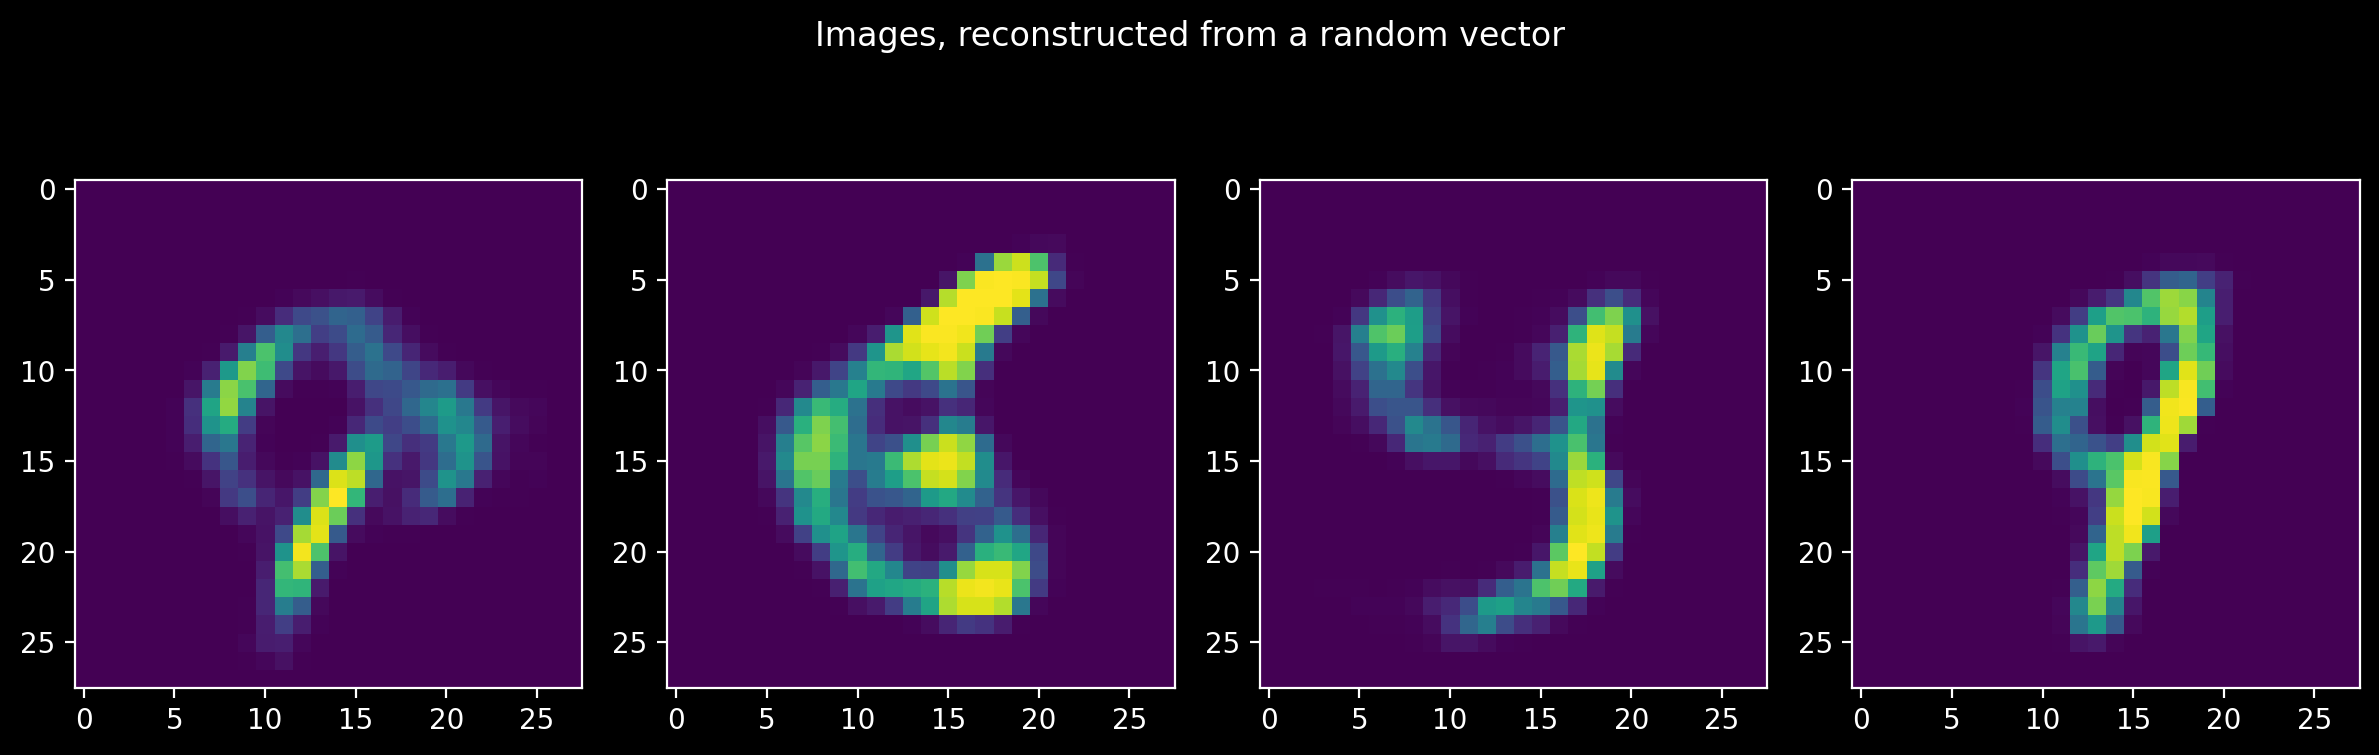

In [27]:
z = torch.randn(10, latent_dim)
output = vae.decode(z.to(device))

n2plot = 4
fig, axs = plt.subplots(1, n2plot, figsize=(3*n2plot, 4))
fig.suptitle("Images, reconstructed from a random vector")

for i in range(n2plot):

    img = torch.moveaxis(output[i].detach().cpu(), 0, 2)

    ax = axs[i]
    ax.imshow(img)

fig.tight_layout()

## 2.2. Latent Representation (2 балла)


Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.

Итак, план:

1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.


In [28]:
latent_vecs = np.empty((0, 16))
for batch, digits in test_loader:
    with torch.no_grad():
        mu, sigma, recon = vae(batch.to(device))
    mu = mu.detach().cpu().numpy()
    latent_vecs = np.concatenate([latent_vecs, mu])

digits = test_dataset.targets.numpy()
latent_vecs = latent_vecs[:len(test_dataset)]

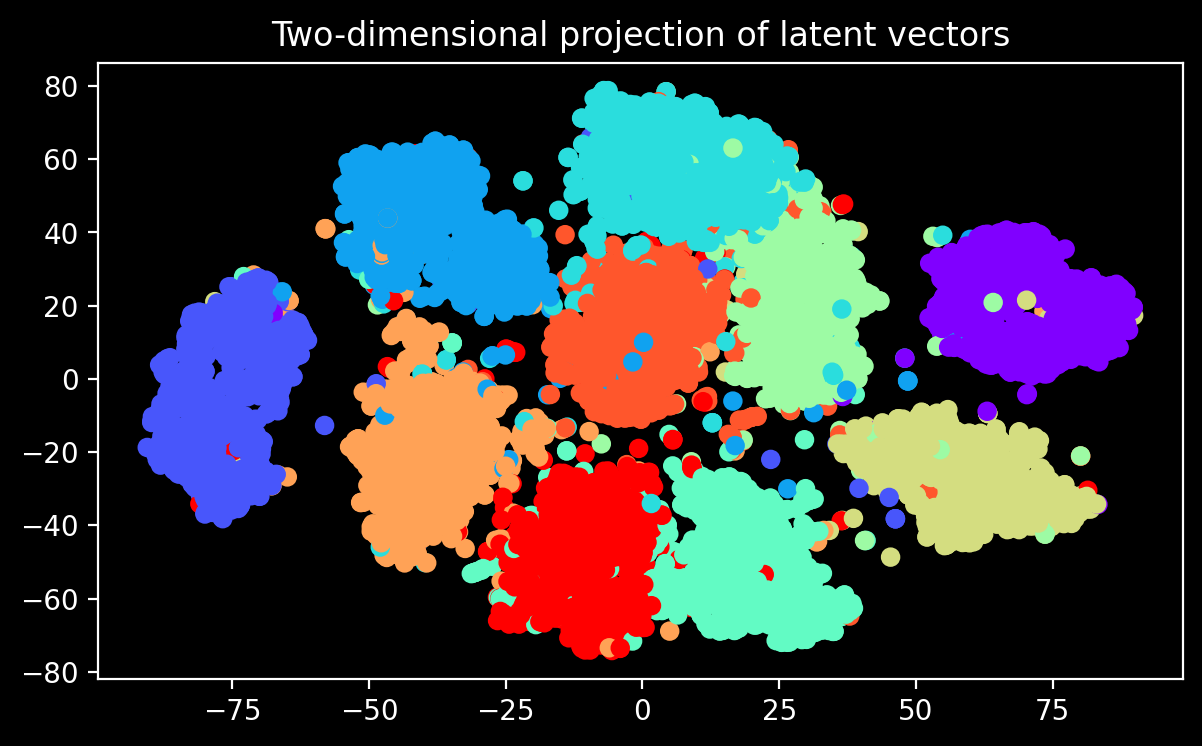

In [29]:
from sklearn.manifold import TSNE

points = TSNE(2, random_state=SEED).fit_transform(latent_vecs)
plt.scatter(points[:, 0], points[:, 1], cmap="rainbow", c=digits)
plt.title("Two-dimensional projection of latent vectors")
plt.show()

Что вы думаете о виде латентного представления?


**Congrats v2.0!**


## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов). Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.


### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)


На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma


Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.


P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.


In [30]:
class CVAE(nn.Module):
    def __init__(self, n_features: int, class_size: int, hidden: int, latent_dim: int):
        super(CVAE, self).__init__()

        self.n_features = n_features

        # encoder
        self.e1 = nn.Linear(n_features + class_size, hidden)
        self.e2a = nn.Linear(hidden, latent_dim)
        self.e2b = nn.Linear(hidden, latent_dim)

        self.d1 = nn.Linear(latent_dim + class_size, hidden)
        self.d2 = nn.Linear(hidden, n_features)

    def encode(self, x, labels):
        x = torch.cat([x, labels], dim=1)
        h1 = F.relu(self.e1(x))
        mu = self.e2a(h1)
        log_var = self.e2b(h1)
        return mu, log_var

    def gaussian_sampler(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z, labels):
        z = torch.cat([z, labels], dim=1)
        h3 = F.relu(self.d1(z))
        recon = F.sigmoid(self.d2(h3)).view(-1, 1, 28, 28)
        return recon

    def forward(self, x, labels):
        mu, log_var = self.encode(x.view(-1, self.n_features), labels)
        z = self.gaussian_sampler(mu, log_var)
        recon = self.decode(z, labels)
        return mu, log_var, recon

In [31]:
def one_hot(labels, class_size=10):
    targets = torch.zeros(labels.shape[0], class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets

In [32]:
latent_dim = 16
criterion = loss_vae
cvae = CVAE(n_features=28*28, class_size=10, hidden=256, latent_dim=latent_dim)
optimizer = torch.optim.AdamW(cvae.parameters(), lr=1e-3)
cvae.to(device)

CVAE(
  (e1): Linear(in_features=794, out_features=256, bias=True)
  (e2a): Linear(in_features=256, out_features=16, bias=True)
  (e2b): Linear(in_features=256, out_features=16, bias=True)
  (d1): Linear(in_features=26, out_features=256, bias=True)
  (d2): Linear(in_features=256, out_features=784, bias=True)
)

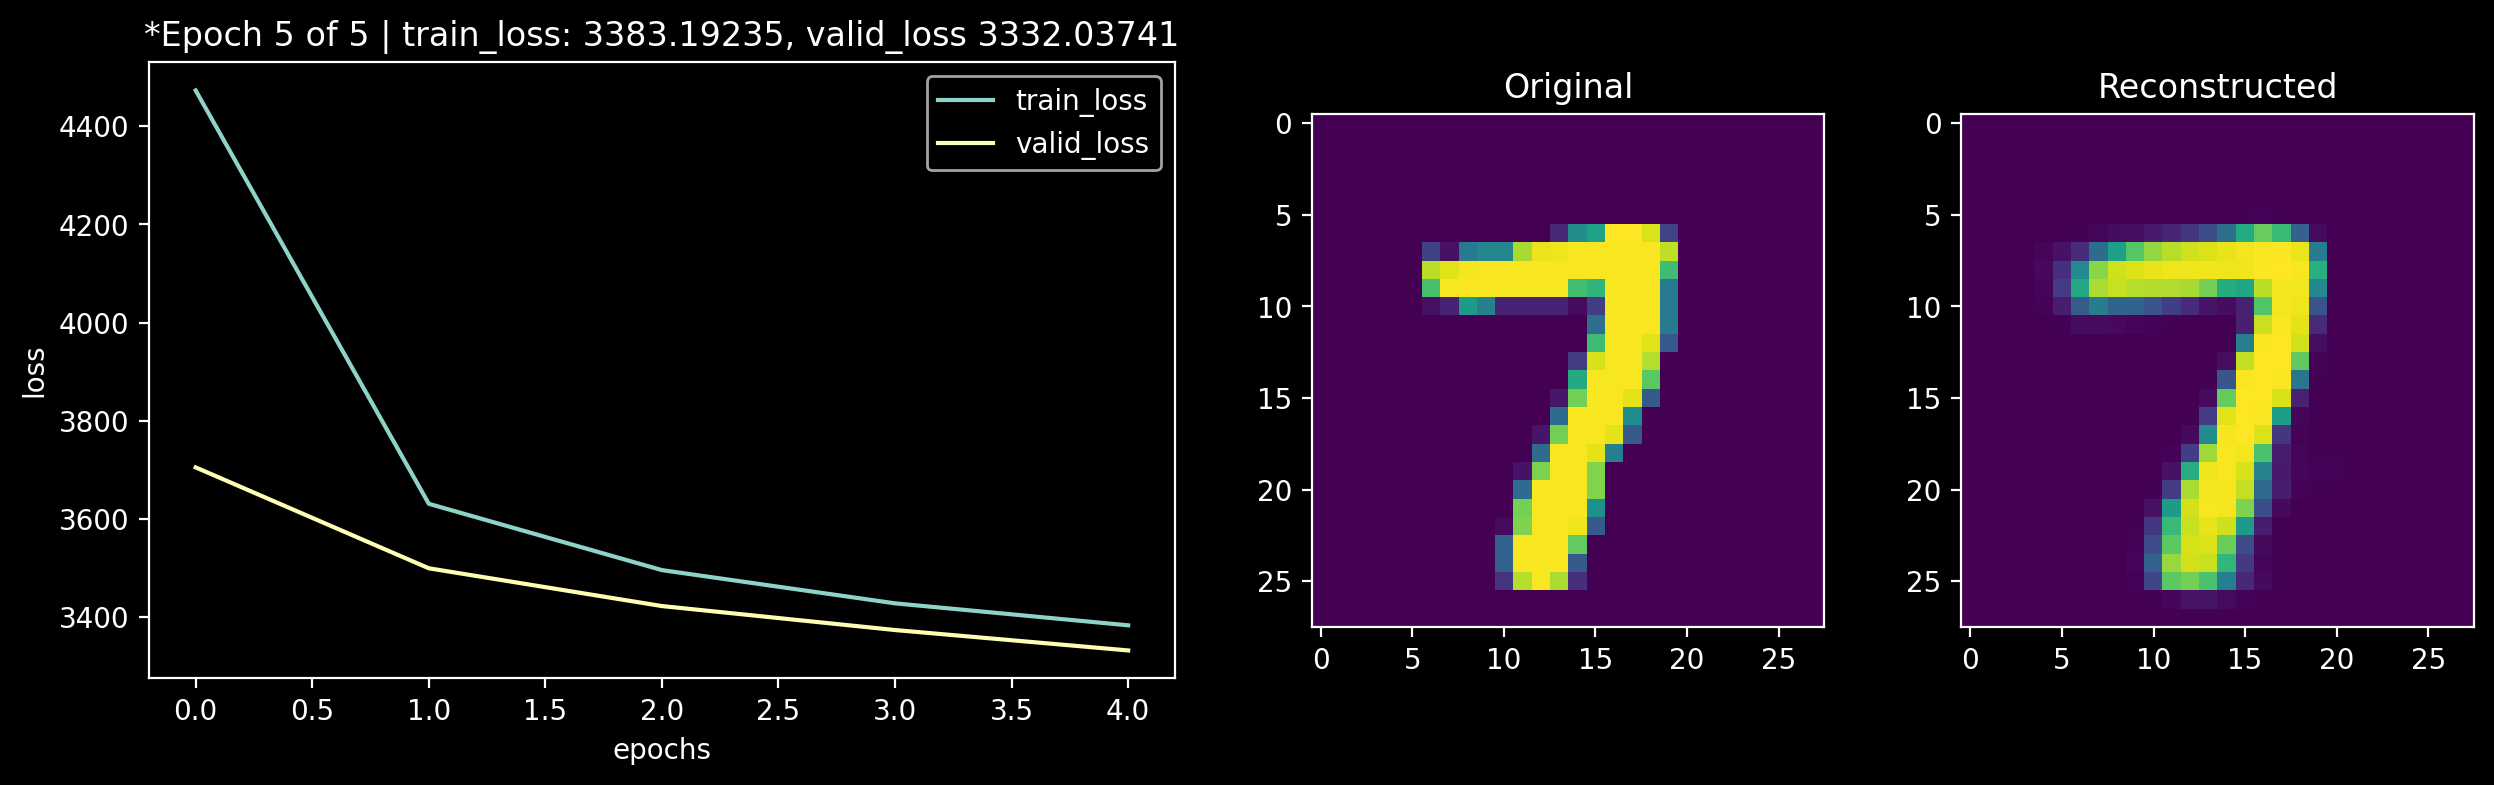

In [33]:
n_epochs = 5
history = {"train_loss": [], "valid_loss": []}

for epoch in range(n_epochs):

    avg_loss_train = 0
    cvae.train()

    for batch, labels in train_loader:
        batch, labels = batch.to(device), labels.to(device)  # data to device
        labels = one_hot(labels).to(device)

        mu, log_var, recon = cvae(batch, labels)
        optimizer.zero_grad()  # reset gradients
        loss = criterion(batch.float(), mu, log_var, recon)

        loss.backward()
        optimizer.step()

        avg_loss_train += loss.item() / len(train_loader)

    history["train_loss"].append(avg_loss_train)

    avg_loss_valid = 0
    cvae.eval()

    with torch.no_grad():
        for test_batch, test_labels in test_loader:
            test_batch, test_labels = test_batch.to(
                device), test_labels.to(device)

            test_labels = one_hot(test_labels).to(device)

            mu, log_var, recon = cvae(test_batch, test_labels)
            loss = criterion(test_batch.float(), mu, log_var, recon)

            avg_loss_valid += loss.item() / len(test_loader)

    history["valid_loss"].append(avg_loss_valid)
    plot_results(history, epoch, n_epochs, test_batch[6], recon[6])